In [119]:
import re
import random
import pandas as pd
import hashlib

In [120]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

if cards_to_age['age'].mean() > 80: age_factor = .5
else: age_factor = 1

cards_to_age['age'] = cards_to_age['age'].fillna(0)
cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.60) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Azure Developer Associate']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.05

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [121]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
"Jane Eyre, Bronte",68.522800,8.565350,17.817033,8
Azure Functions + Visual Studio,162.172567,54.057522,134.828441,3
Azure AD Authentication,388.453731,32.371144,99.906962,12
Logging in Python,395.467787,28.247699,74.090500,14
Email Auth and Security,424.418203,53.052275,128.060206,8
RAG Project,751.287140,75.128714,216.850281,10
Azure Private DNS,860.926322,45.311912,118.051198,19
Debugging in VS Code,862.753067,78.432097,210.484751,11
C# Basics,968.873795,31.253993,102.372754,31
Azure Functions + PP365,1303.924280,62.091632,186.313956,21


# Histogram

sum of ages: ~32813.19


<Axes: >

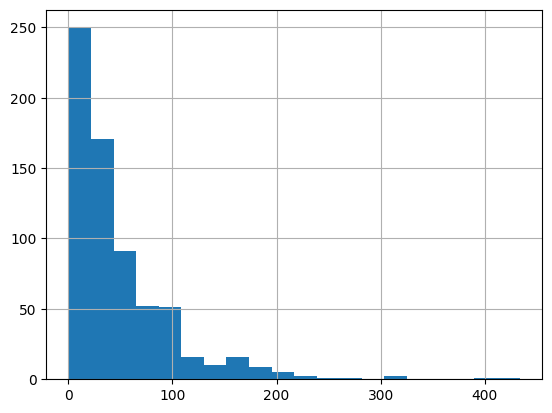

In [122]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

sum of ages: ~32813.19


<Axes: >

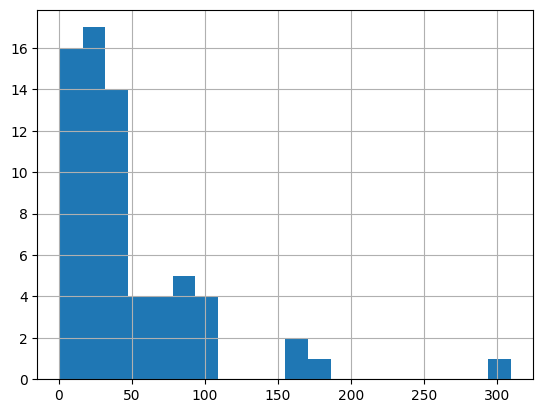

In [123]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards[existing_cards['head']=='Azure Developer Associate']['age'].hist(bins=20)

# Completely Random Shuffle

In [124]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [125]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# Headers with fewest notes first

In [126]:
# frequency = existing_cards['head'].value_counts(ascending=True)

# existing_cards = pd.merge(
#     left=existing_cards,
#     right=frequency.rename('frequency'),
#     left_on='head', right_index=True,
#     how='left'
# )
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] * -1
# existing_cards['age'] = existing_cards['age'] * -1


# existing_cards.sort_values(['frequency', 'subject_highest_age', 'age'], ascending=True, inplace=True)

# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

# existing_cards.head(10)

## Headers with greatest age sum first

In [127]:
# existing_cards.sort_values(['subject_age_sum', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)
# existing_cards.head(10)

## Header with oldest cards first

In [128]:
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards.sort_values(['oldest', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# Focus on one header

In [129]:
# heads = existing_cards['head'].value_counts()
# heads = heads[heads > 5].index.tolist()
# one_header = random.sample(heads, 1)[0]
# existing_cards['pick_head'] = existing_cards['head'].apply(
#     lambda h: 0 if h == one_header else 1 
# )

# remake_card_document(existing_cards=existing_cards.sort_values('pick_head'))

## Headers with greatest mean card age first

In [130]:
# existing_cards.sort_values(['subject_mean_age', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# N-fold shuffle


## Age Sum

In [131]:
# n=3
# m=existing_cards.shape[0]//100
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [132]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)

## Age Max

In [133]:
n = 3
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] % n

if existing_cards['age'].sum() > 0:
    existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
    existing_cards['neg_age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# existing_cards.sort_values(['age'], inplace=True)

remake_card_document(existing_cards=existing_cards)
existing_cards.head(10)


Cards found: 679
Total card age: 32813.19


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold,neg_age
68,PnP PowerShell,Get-PnPListItem (PnP.PowerShell)\nFetches item...,a295fdb6e499a07c6a69b084bf979f77,433.389630,55.803706,-433.38963,3348.222376,0.020891,0,0,-433.389630
69,PnP PowerShell,New-AzureADApplication (AzureAD)\nCreates a ne...,1ca5018f16e176fb04a8c920e8c2825e,171.180061,55.803706,-433.38963,3348.222376,0.020891,3,0,-171.180061
528,PnP PowerShell,SharePoint Permissions Levels\nPredefined or c...,f935e66a1ca97abd106f064514386653,153.643748,55.803706,-433.38963,3348.222376,0.020891,6,0,-153.643748
71,PnP PowerShell,Get-PnPList (PnP.PowerShell)\nRetrieves a Shar...,2997503edd622f398ca08b3707a18544,97.309903,55.803706,-433.38963,3348.222376,0.020891,9,0,-97.309903
72,PnP PowerShell,Write-Verbose (Microsoft.PowerShell.Utility)\n...,e2537899e2fb89815237d7fe0a3bd8e9,86.317984,55.803706,-433.38963,3348.222376,0.020891,12,0,-86.317984
73,PnP PowerShell,Secure Password Handling\nPractices for managi...,274158ed857c87a86d296e65705f10da,62.908354,55.803706,-433.38963,3348.222376,0.020891,15,0,-62.908354
74,PnP PowerShell,New-Object (Microsoft.PowerShell.Utility)\nCre...,985de2015a6f41fa0285e934d18ecf90,50.732794,55.803706,-433.38963,3348.222376,0.020891,18,0,-50.732794
533,PnP PowerShell,Remove-PnPFile (PnP.PowerShell)\nDeletes a spe...,82aa6d1579ce68a7efaf6bae61eb3a03,44.883973,55.803706,-433.38963,3348.222376,0.020891,21,0,-44.883973
76,PnP PowerShell,CSOM (Client-Side Object Model)\nAn alternativ...,6c7bad42552cc2a39f8ff9880d066546,33.990423,55.803706,-433.38963,3348.222376,0.020891,24,0,-33.990423
77,PnP PowerShell,ConvertFrom-SecureString (Microsoft.PowerShell...,b0b4929ceace8c20afb149c725b37fc2,31.876361,55.803706,-433.38963,3348.222376,0.020891,27,0,-31.876361


## Card Count

In [134]:
# n=4
# existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'frequency', 'neg_age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)


## Random

In [135]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [136]:
existing_cards.sort_values('age', ascending=True).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold,neg_age
239,Debugging in VS Code,Watchpoint\nA debugging feature that pauses ex...,7220771e05c8839276baa18cb1797fb2,0.310196,78.432097,-210.484751,862.753067,0.591770,10,1,-0.310196
222,Vocab,"How to Sell a Haunted House, Hendrix\nCodicil\...",1de7e737fadc28eb277f75c71abda291,0.379001,28.831302,-159.057730,2623.648455,0.520119,90,0,-0.379001
672,Vocab,"How to Sell a Haunted House, Hendrix\nTulle\nP...",c8404b20be2c59d64bc56fa8551eab2d,0.668191,28.831302,-159.057730,2623.648455,0.520119,89,2,-0.668191
392,Azure Developer Associate,You manage an Azure event hub.\nYou need to en...,838e25a55fa8576e625cbde1871dbfd0,0.801450,46.967812,-309.566419,3193.811239,0.401281,67,1,-0.801450
176,VMWare,Host Failure\n\nWhen a physical ESXi host beco...,50554350b937a4d45efe1e2ea91d1c85,1.103150,32.710568,-127.942991,1406.554415,0.525973,42,0,-1.103150
230,"Jane Eyre, Bronte","Cachinnation (kak-ih-NAY-shun)\nLoud, uncontro...",5a55925ded4db77d8d93e5fc0dd1655c,1.153277,8.565350,-17.817033,68.522800,0.722228,7,1,-1.153277
191,C# Basics,Lambda expressions provide a concise way to re...,059a0c05a32a63a831c1c5515f10e488,1.158679,31.253993,-102.372754,968.873795,0.915399,30,0,-1.158679
449,Vocab,"How to Sell a Haunted House, Hendrix\nDebride ...",1cbf1056a2336f69233d814a8be086c8,1.222682,28.831302,-159.057730,2623.648455,0.520119,88,1,-1.222682
325,Email Auth and Security,MUA (Mail User Agent)\n\nAn email client used ...,728b4872797d6311a0966fa924d6341d,1.330693,53.052275,-128.060206,424.418203,0.196352,7,1,-1.330693
488,PowerShell Modules,Module Load Order\n\nDefinition: The sequence ...,a73a2a72233bd246a7d370085061e59a,1.880939,65.533976,-315.341765,2424.757115,0.988080,36,0,-1.880939


In [137]:
existing_cards.head(10).sum()

head                   PnP PowerShellPnP PowerShellPnP PowerShellPnP ...
body                   Get-PnPListItem (PnP.PowerShell)\nFetches item...
hash                   a295fdb6e499a07c6a69b084bf979f771ca5018f16e176...
age                                                          1166.233231
subject_mean_age                                              558.037063
subject_highest_age                                           -4333.8963
subject_age_sum                                             33482.223761
head_random_roll                                                0.208915
count                                                                135
n_fold                                                                 0
neg_age                                                     -1166.233231
dtype: object

In [138]:
existing_cards['age'].mean()

48.32575924062569